# NLP Hate Speech Classification Model

## Datasource

The dataset we will be the tweets along with hate speech classification labels. 
We will strive for **Detecting Hate Speech** in people's tweets.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Load the dataset

In [2]:
tweets = pd.read_csv('tweets.csv')
tweets.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
tweets.shape

(5242, 3)

1 --> hate speech 
0 --> not hate speech

In [4]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5242 entries, 0 to 5241
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5242 non-null   int64 
 1   label   5242 non-null   int64 
 2   tweet   5242 non-null   object
dtypes: int64(2), object(1)
memory usage: 123.0+ KB


In [5]:
tweets['label'].value_counts()

0    3000
1    2242
Name: label, dtype: int64

Let us visualize the tweets for general understanding

In [6]:
tweets['tweet']

0        @user when a father is dysfunctional and is s...
1       @user @user thanks for #lyft credit i can't us...
2                                     bihday your majesty
3       #model   i love u take with u all the time in ...
4                  factsguide: society now    #motivation
                              ...                        
5237    lady banned from kentucky mall. @user  #jcpenn...
5238    @user omfg i'm offended! i'm a  mailbox and i'...
5239    @user @user you don't have the balls to hashta...
5240     makes you ask yourself, who am i? then am i a...
5241    @user #sikh #temple vandalised in in #calgary,...
Name: tweet, Length: 5242, dtype: object

## Data Preprocessing & Feature Engineering

In [7]:
#RegEx import
import re
from wordcloud import WordCloud, STOPWORDS

In [8]:
def clean_text(text):
    #Alphabets filter
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    #Unicode characters, if any will be removed
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    #Lowercasing for uniformity
    text = text.lower()
       
    return text

In [9]:
tweets['clean_text'] = tweets['tweet'].apply(lambda x: clean_text(x))

In [10]:
tweets[['tweet','clean_text']]

,tweet,clean_text
0,@user when a father is dysfunctional and is s...,user when a father is dysfunctional and is s...
1,@user @user thanks for #lyft credit i can't us...,user user thanks for lyft credit i can't us...
2,bihday your majesty,bihday your majesty
3,#model i love u take with u all the time in ...,model i love u take with u all the time in ...
4,factsguide: society now #motivation,factsguide society now motivation
...,...,...
5237,lady banned from kentucky mall. @user #jcpenn...,lady banned from kentucky mall user jcpenn...
5238,@user omfg i'm offended! i'm a mailbox and i'...,user omfg i'm offended i'm a mailbox and i'...
5239,@user @user you don't have the balls to hashta...,user user you don't have the balls to hashta...
5240,"makes you ask yourself, who am i? then am i a...",makes you ask yourself who am i then am i a...


In [11]:
STOPWORDS

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 

In [12]:
#Helper function to generate word frequency
def generate_word_freq(text):
    word_list = []

    for tw_words in text.split():
        word_list.extend(tw_words)

    word_freq = pd.Series(word_list).value_counts()    
    word_freq = word_freq.drop(STOPWORDS, errors='ignore')
    
    return word_freq

#Helper function to find negative words
def find_negative_word(words):
    for word in words:
        if word in ['n', 'no', 'non', 'not'] or re.search(r"\wn't", word):
            return 1
    else:
        return 0

#Helper function to find rare words
def find_rare_word(words, rare_100):
    for word in words:
        if word in rare_100:
            return 1
    else:
        return 0

#Helper function to find interrogative words
def is_question_word(words):
    for word in words:
        if word in ['when', 'what', 'how', 'why', 'who']:
            return 1
    else:
        return 0

In [13]:
word_freq = generate_word_freq(tweets['clean_text'].str)

#100 most rare words in the dataset
rare_100 = word_freq[-100:]

#Number of words in a tweet
tweets['word_count'] = tweets['clean_text'].str.split().apply(lambda x: len(x))

#Negation present or not
tweets['negative_term_present'] = tweets['clean_text'].str.split().apply(lambda x: find_negative_word(x))

#Prompt present or not
tweets['is_question_word'] = tweets['clean_text'].str.split().apply(lambda x: is_question_word(x))

#Any of the most 100 rare words present or not
tweets['rare_word_present'] = tweets['clean_text'].str.split().apply(lambda x: find_rare_word(x, rare_100))

#Character count of the tweet
tweets['char_count'] = tweets['clean_text'].apply(lambda x: len(x))

In [14]:
#Top 10 common words in Word Frequency table
word_freq[:10]

user      3351
amp        439
love       320
day        254
trump      214
happy      207
will       191
people     186
new        171
u          158
dtype: int64

In [15]:
tweets.head()

,id,label,tweet,clean_text,word_count,negative_term_present,is_question_word,rare_word_present,char_count
0,1,0,@user when a father is dysfunctional and is s...,user when a father is dysfunctional and is s...,18,0,1,0,102
1,2,0,@user @user thanks for #lyft credit i can't us...,user user thanks for lyft credit i can't us...,19,1,0,0,122
2,3,0,bihday your majesty,bihday your majesty,3,0,0,0,21
3,4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ...,12,0,0,0,86
4,5,0,factsguide: society now #motivation,factsguide society now motivation,4,0,0,0,39


#### Word Cloud for Tweets

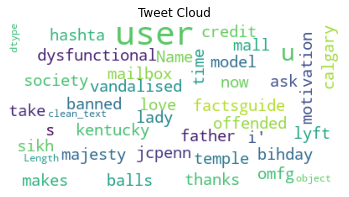

In [16]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=STOPWORDS,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(tweets['clean_text']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.title('Tweet Cloud')
plt.axis('off')
plt.show()
fig.savefig("tweet_cloud.png", dpi=900)

## Train-Test split for Model Building

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X = tweets[['word_count', 'negative_term_present', 'is_question_word', 'rare_word_present', 'char_count']]
y = tweets.label

#Stratified split to conserve Target label distribution in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=24)

In [19]:
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4193, 5)

(1049, 5)

(4193,)

(1049,)

## Text Classification Model Building

In [20]:
#Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#Model Evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, log_loss
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix, plot_precision_recall_curve

In [21]:
def classifier_metrics(classifier):
  """
  Helper function to plot Univariate features.
  Input  : Classifier; 
  Output : Accuracy, Classification Report, Confusion Matrix, ROC AUC Curve, Precision-Recall Curve 
  """
  y_true, y_pred = y_test, classifier.predict(X_test)
  train_accuracy = classifier.score(X_train, y_train).round(3)
  test_accuracy = classifier.score(X_test, y_test).round(3)
  print("Train Accuracy : ", train_accuracy)
  print("Test Accuracy : ", test_accuracy)
  
  # Classification Report
  print("\nClassification Report")
  print('\n{}'.format(classification_report(y_true, y_pred)))
    
  # Precision Score
  clf_precision = precision_score(y_true, y_pred)
  print('\nPrecision Score:\n', clf_precision.round(3))
  
  # Recall Score
  clf_recall = recall_score(y_true, y_pred)
  print('\nRecall Score:\n', clf_recall.round(3))
  
  # F1 Score
  clf_f1 = f1_score(y_true, y_pred)
  print('\nF1 Score:\n', clf_f1.round(3))
  
  # ROC AUC Score
  clf_roc_auc = roc_auc_score(y_true, y_pred)
  print('\nROC AUC Score:\n', clf_roc_auc.round(3))

  #Gini-Coefficient
  clf_gini_coeff = 2 * clf_roc_auc -1
  print("\nGini Coefficient :\n", clf_gini_coeff.round(2))
  
  # Confusion Matrix
  clf_conf_matrix = confusion_matrix(y_true, y_pred)
  print('\nConfusion Matrix:\n')
  sns.heatmap(clf_conf_matrix, annot=True, square=True, fmt='g')

  #ROC AUC Curve
  clf_fpr, clf_tpr, clf_thresholds = roc_curve(y_true, classifier.predict_proba(X_test)[:,1])

  plt.figure(figsize = (14 , 6))
  plt.plot(clf_fpr, clf_tpr, label = 'Classifier AUC (area = {})'.format(clf_roc_auc.round(2)))
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc = 'lower right')
  plt.show()

  #Precision-Recall Curve
  plt.figure(figsize=(14,6))
  plot_precision_recall_curve(classifier, X_test, y_test)
  plt.title("Precision-Recall AUC Curve")
  plt.legend(loc = 'lower right')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.show()

  return train_accuracy, test_accuracy, clf_conf_matrix, clf_precision, clf_recall, clf_f1, clf_roc_auc, clf_gini_coeff,clf_fpr, clf_tpr, clf_thresholds

In [22]:
#Instantiating the Models

#Gaussian Naive Bayes
gnb_clf = GaussianNB()

#Logistic Regression
lr_clf = LogisticRegression(
    solver='lbfgs', 
    penalty='l2', 
    C=1.0, 
    max_iter=100, 
    n_jobs=-1, 
    random_state=24)

#Random Forest Classifier
rf_clf = RandomForestClassifier(
    n_estimators=100,
    criterion='entropy',
    max_depth=None,
    max_features='auto',
    oob_score=True,
    n_jobs=-1,
    random_state=24
)

Fit the model on the trainset

In [23]:
gnb_clf = gnb_clf.fit(X_train, y_train)

Train Accuracy :  0.58
Test Accuracy :  0.592

Classification Report

              precision    recall  f1-score   support

           0       0.61      0.81      0.69       600
           1       0.54      0.31      0.39       449

    accuracy                           0.59      1049
   macro avg       0.57      0.56      0.54      1049
weighted avg       0.58      0.59      0.56      1049


Precision Score:
 0.542

Recall Score:
 0.305

F1 Score:
 0.39

ROC AUC Score:
 0.556

Gini Coefficient :
 0.11

Confusion Matrix:



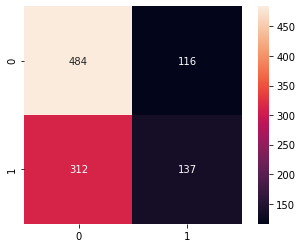

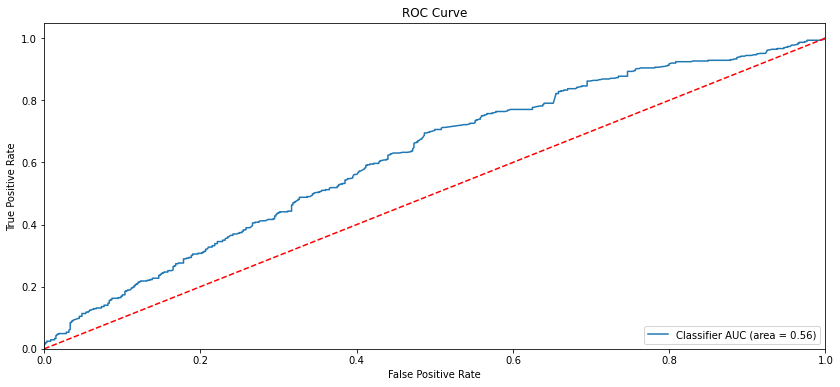

<Figure size 1008x432 with 0 Axes>

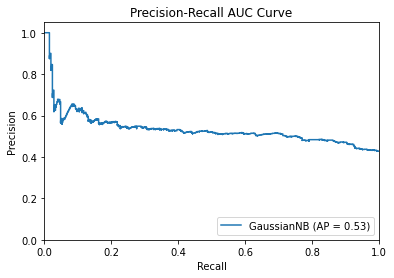

In [24]:
gnb_train_accuracy, gnb_test_accuracy, gnb_clf_conf_matrix, gnb_clf_precision, gnb_clf_recall, gnb_clf_f1, gnb_clf_roc_auc, gnb_clf_gini_coeff, gnb_clf_fpr, gnb_clf_tpr, gnb_clf_thresholds = classifier_metrics(gnb_clf)

In [25]:
lr_clf.fit(X_train, y_train)

LogisticRegression(n_jobs=-1, random_state=24)

Train Accuracy :  0.588
Test Accuracy :  0.585

Classification Report

              precision    recall  f1-score   support

           0       0.59      0.89      0.71       600
           1       0.55      0.18      0.28       449

    accuracy                           0.59      1049
   macro avg       0.57      0.53      0.49      1049
weighted avg       0.57      0.59      0.52      1049


Precision Score:
 0.546

Recall Score:
 0.185

F1 Score:
 0.276

ROC AUC Score:
 0.535

Gini Coefficient :
 0.07

Confusion Matrix:



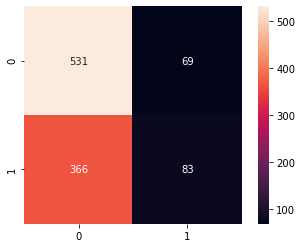

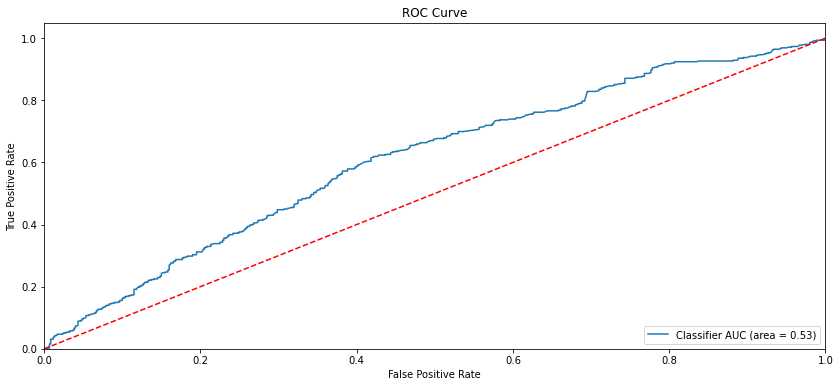

<Figure size 1008x432 with 0 Axes>

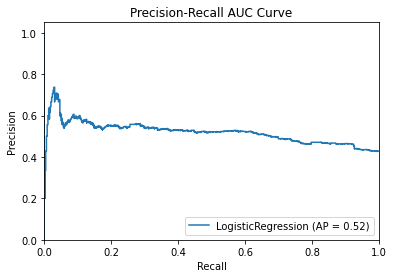

In [26]:
lr_train_accuracy, lr_test_accuracy, lr_clf_conf_matrix, lr_clf_precision, lr_clf_recall, lr_clf_f1, lr_clf_roc_auc, lr_clf_gini_coeff, lr_clf_fpr, lr_clf_tpr, lr_clf_thresholds = classifier_metrics(lr_clf)

In [27]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_jobs=-1, oob_score=True,
                       random_state=24)

In [28]:
rf_clf.oob_score_

0.595754829477701

Train Accuracy :  0.806
Test Accuracy :  0.601

Classification Report

              precision    recall  f1-score   support

           0       0.64      0.69      0.66       600
           1       0.54      0.48      0.51       449

    accuracy                           0.60      1049
   macro avg       0.59      0.59      0.59      1049
weighted avg       0.60      0.60      0.60      1049


Precision Score:
 0.537

Recall Score:
 0.483

F1 Score:
 0.509

ROC AUC Score:
 0.586

Gini Coefficient :
 0.17

Confusion Matrix:



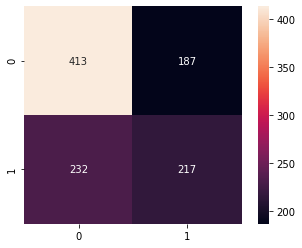

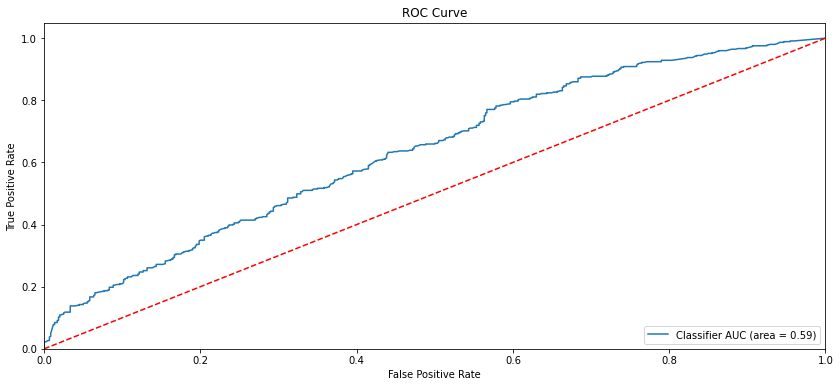

<Figure size 1008x432 with 0 Axes>

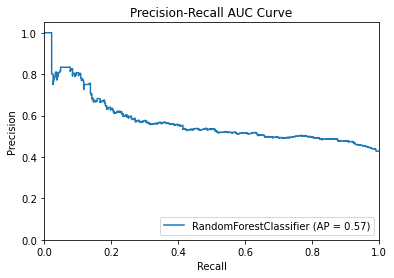

In [29]:
rf_train_accuracy, rf_test_accuracy, rf_clf_conf_matrix, rf_clf_precision, rf_clf_recall, rf_clf_f1, rf_clf_roc_auc, rf_clf_gini_coeff, rf_clf_fpr, rf_clf_tpr, rf_clf_thresholds = classifier_metrics(rf_clf)

## Model Comparison and Selection

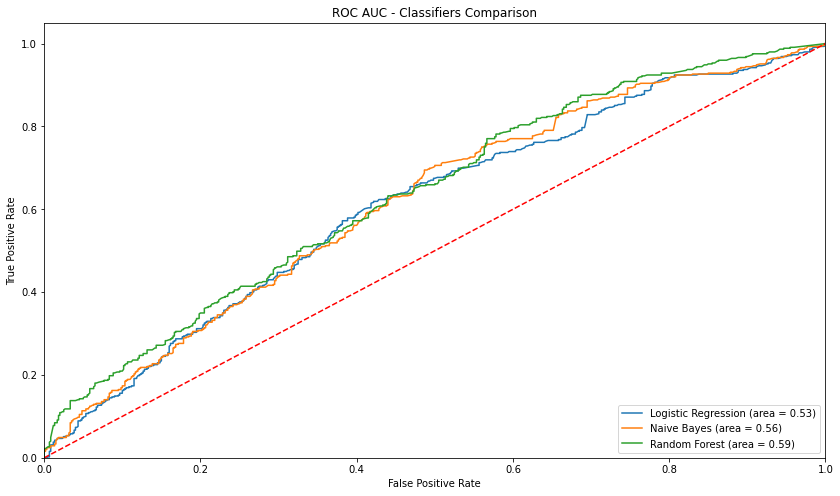

In [30]:
plt.figure(figsize = (14 , 8))

plt.plot(lr_clf_fpr, lr_clf_tpr, label = 'Logistic Regression (area = {})'.format(lr_clf_roc_auc.round(2)))

plt.plot(gnb_clf_fpr, gnb_clf_tpr, label = 'Naive Bayes (area = {})'.format(gnb_clf_roc_auc.round(2)))

plt.plot(rf_clf_fpr, rf_clf_tpr, label = 'Random Forest (area = {})'.format(rf_clf_roc_auc.round(2)))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC - Classifiers Comparison')
plt.legend(loc = 'lower right')
plt.show()

In [31]:
metrics = {'Classifier':['Logistic Regression',
                         'Gaussian Naive Bayes',
                         'Random Forest'],
           'Accuracy' : [lr_test_accuracy,
                         gnb_test_accuracy,
                         rf_test_accuracy],
           'Precision':[lr_clf_precision,
                        gnb_clf_precision,
                        rf_clf_precision],
           'Recall':[lr_clf_recall,
                     gnb_clf_recall,
                     rf_clf_recall], 
           'F1-Score':[lr_clf_f1,
                       gnb_clf_f1,
                       rf_clf_f1], 
           'ROC AUC':[lr_clf_roc_auc,
                      gnb_clf_roc_auc,
                      rf_clf_roc_auc], 
           'Gini Coeff':[lr_clf_gini_coeff,
                         gnb_clf_gini_coeff,
                         rf_clf_gini_coeff]
          }
model_eval_metrics = pd.DataFrame(metrics)
model_eval_metrics = model_eval_metrics.set_index('Classifier')

In [32]:
model_eval_metrics

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Gini Coeff
Classifier,,,,,,
Logistic Regression,0.585,0.546053,0.184855,0.276206,0.534928,0.069855
Gaussian Naive Bayes,0.592,0.541502,0.305122,0.390313,0.555895,0.111789
Random Forest,0.601,0.537129,0.483296,0.508792,0.585815,0.171630


In [33]:
print("Best Performance Model :\n")
model_eval_metrics.idxmax()

Best Performance Model :



Accuracy            Random Forest
Precision     Logistic Regression
Recall              Random Forest
F1-Score            Random Forest
ROC AUC             Random Forest
Gini Coeff          Random Forest
dtype: object

## Summary

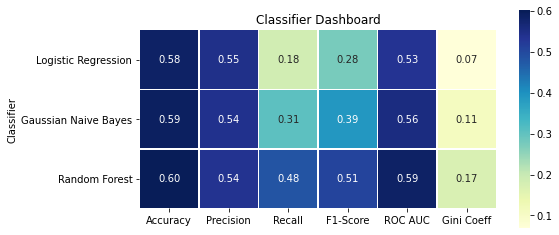

In [34]:
plt.figure(figsize=(8,4))
sns.heatmap(model_eval_metrics, annot=True, linewidths = 0.4, square=True, fmt='.2f', cmap='YlGnBu').set_title('Classifier Dashboard')
plt.show()